<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/ML_HIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Update remove duplicate between train and test --> create independent test
check why test set after removing the intersection (aka independent test) has no frequent record? --> no, set(independent test) has fewer records than independent test.
So the previous clean_data method removes duplication and overlap instances, while the new method (remove_duplicate) only removes overlap instance


!rm *.txt
! rm *.int

In [55]:
#@title Specify parameters before running


SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

BATCH_SZ =  32#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

EPOCHS =  2#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = False #@param {type:"boolean"}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

import nltk
nltk.download("popular")

## Tokenizing syscall sequences into n-grams of 6

from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

#**Processing data**

Use the given datasets in our GitHub to load the data

In [3]:
  ## Uncomment each line to load Normal data

# Synthetic sendmail csv_file = ['bounce-1.int', 'bounce.int', 'bounce-2.int', 'plus.int', 'queue.int', 'sendmail.daemon.int', 'sendmail.log.int']; DATA = 'Synthetic Sendmail'; DATA_I='Synthetic_Sendmail'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/bounce-2.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/plus.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/queue.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/sendmail.daemon.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/normal-data/sendmail.log.int'

# LIVE LPR csv_file = ['lpr-normal-10.txt', 'lpr-normal-11.txt']; DATA = 'Live Lpr'; DATA_I='Live-Lpr' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-11.txt'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Normal/real/lpr-normal-10.txt'

# MIT live lpr 
csv_file = [ 'mit-lpr-mar.txt']; DATA = 'MIT Live Lpr'; DATA_I='MIT-Lpr' 
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/mit-lpr-mar.txt'

# LOGIN and PS csv_file = [ 'login-normal.txt', 'ps-normal.txt']; DATA = 'Login and Ps'; DATA_I ="Login-and-Ps"
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/normal/login-normal.txt'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/normal/ps-normal.txt'

# INETD csv_file = [ 'inetd-live-unm.int']; DATA = 'Inetd';DATA_I ="Inetd" 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/8.Inetd/inetd-live-unm.int'

# STIDE csv_file = [ 'stide-normal-500k.txt']; DATA = 'Stide';DATA_I ='Stide' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/stide-normal-500k.txt'

# Live Named  csv_file = [ 'normal-named-live-2k.txt']; DATA = 'Live Named';DATA_I ='Live-Named' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/normal-named-live-2k.txt'

# Xlock csv_file = [ 'normal-xlock.txt']; DATA = 'Xlock';DATA_I='Xlock' 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/normal-xlock.txt'

# Synthetic Ftp 
#csv_file = [ 'nonself1.int','nonself2.int']; DATA = 'Synthetic Ftp'; DATA_I='Synthetic-Ftp'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/nonself1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/nonself2.int'

# Synthetic lpr csv_file = ['syn.int']; DATA = 'Synthetic Lpr';DATA_I='Synthetic-Lpr'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/3.Synthetic-lpr/syn.int'

# Concat a list of files into normal df
list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
df = pd.concat(list_of_dataframes)

# Check number of columns, if > 2, then drop the excess
if len(df.columns) > 2:
    df=df.drop(labels=None, axis=1, columns = [2,3])
df =df.rename(columns= {0:"PID", 1:"Syscall"})

print('Normal data size:', df.shape)


  ## Uncomment each line to load Intrusion data:

# Synthetic sendmail csv_file = ['sm-10763.int', 'fwd-loops-1.int', 'fwd-loops-2.int', 'fwd-loops-3.int', 'fwd-loops-4.int', 'fwd-loops-5.int','sm-280.int', 'sm-314.int','sm-10801.int', 'sm-10814.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-2.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-3.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-4.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/fwd-loops-5.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10763.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-280.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-314.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10801.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/1.Synthetic%20Sendmail/Intrusion-trace-data/sm-10814.int'

# LIVE LPR csv_file =['exploit-unm.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/4.%20Live%20lpr/Intrusion/exploit-unm.int'

# MIT live lpr 
csv_file = [ 'exploit-ai.int'] 
!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/exploit-ai.int'

# LOGIN and PS csv_file = [ 'login-homegrown.int','ps-homegrown.int','login-recovered.int','ps-recovered.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/ps-recovered.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/ps-homegrown.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/login-recovered.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/7.Login_and_ps/intrusion/login-homegrown.int'

# INETD csv_file = [ 'inetd-intrusion.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/8.Inetd/intrusion/inetd-intrusion.int'

# STIDE csv_file = [ 'stide-intrusion'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/10.Stide/intrusion/stide-intrusion'

# Live Named  csv_file = [ 'exploit-1.int','exploit-2.int'] 
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/intrusion/exploit-1.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/6.Live_named/intrusion/exploit-2.int'

# Xlock csv_file = [ 'nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int', 'nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/intrusion/nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int'
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/5.xlock/intrusion/nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int'

# Synthetic Ftp csv_file = [ 'exploit2.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/2.Synthetic%20Ftp/intrusion/exploit2.int'

# Synthetic Lpr csv_file = [ 'exploit-unm.int']
#!wget 'https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/UNM/3.Synthetic-lpr/intrusion/exploit-unm.int'

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
intrusiondf = pd.concat(list_of_dataframes)

if len(intrusiondf.columns) > 2:
    intrusiondf = intrusiondf.drop(labels=None, axis=1, columns = [2,3])
intrusiondf = intrusiondf.rename(columns= {0:"PID", 1:"Syscall"})

print('intrusion data size: ', intrusiondf.shape)

print('Normal:',df.head(3))
#print(df['PID'].value_counts())
print('Intrusion:',intrusiondf.head())

--2022-02-19 18:12:00--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/mit-lpr-mar.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1359870 (1.3M) [text/plain]
Saving to: ‘mit-lpr-mar.txt’

mit-lpr-mar.txt     100%[===================>]   1.30M  --.-KB/s    in 0.04s   

2022-02-19 18:12:01 (33.8 MB/s) - ‘mit-lpr-mar.txt’ saved [1359870/1359870]

Normal data size: (174260, 2)
--2022-02-19 18:12:02--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/MIT/exploit-ai.int
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

**Change to covert all syscall of 1 PID into a data record. Pasrse each data record to a length of 10 or 15, clean frequent records.**

In [4]:
print('Number of unique PID in normal data:', len(df['PID'].value_counts()))
df

Number of unique PID in normal data: 327


,PID,Syscall
0,12561,5
1,12561,3
2,12561,67
3,12561,67
4,12561,5
...,...,...
174255,22266,6
174256,22266,6
174257,22266,6
174258,22266,6


In [5]:
print('Number of unique PID in intrusion data:', len(intrusiondf['PID'].value_counts()))
intrusiondf

Number of unique PID in intrusion data: 1001


,PID,Syscall
0,7174,4
1,7174,2
2,7174,66
3,7174,66
4,7174,4
...,...,...
165243,9209,9
165244,9209,9
165245,9209,5
165246,9209,5


**Create syscall sequence per pid**

In [6]:
# This function groups data by PID, so the sequences appear by PID instead of by order, in case it was interrupted by other PID
## It returns a dict with PID as key and syscall seq as item
def group_syscalls_by_pid (data):
  seq_per_pid = {}
  for p in data['PID'].unique():
    filt = data['PID'] == p
    seq = data.loc[filt]['Syscall'].values.astype(str)
    seq_per_pid[p] = ' '.join(seq)
  return seq_per_pid

# Group normal df by PID and drop PID column
normal_seq_per_pid = group_syscalls_by_pid(df)
print('Number of unique PID in normal:', len(normal_seq_per_pid))
#print('Normal PIDs and its sequences: ',normal_seq_per_pid)

# Do the same thing to intrusion PID
intrusion_seq_per_pid = group_syscalls_by_pid(intrusiondf)
print('Number of unique PID in intrusion:', len(intrusion_seq_per_pid))
#print('Intrusion PIDs and its sequences: ', intrusion_seq_per_pid)

Number of unique PID in normal: 327
Number of unique PID in intrusion: 1001


In [7]:
# Drop a sequence if its total len is less than 3
def remove_small_seq(pid_seq_dict):
  removed_pid = []
  for pid in pid_seq_dict:
    seq_list = pid_seq_dict[pid].split()
    if len(seq_list) < 3:
      print('Remove PID %d which only has %d syscals in its sequence: %s' % (pid, len(seq_list), pid_seq_dict[pid]))
      removed_pid.append(pid)

  [pid_seq_dict.pop(pid) for pid in removed_pid]
  return pid_seq_dict

# Clean small intrusion sequences
print('Clean small normal seq: \nNum PID in Normal before:', len(normal_seq_per_pid))
normal_seq_per_pid = remove_small_seq(normal_seq_per_pid)
print('Num PID in Normal after:', len(normal_seq_per_pid))

# Clean small intrusion sequences
print('\n\nClean small intrusion seq: \nNum PID in Intrusion before:', len(intrusion_seq_per_pid))
intrusion_seq_per_pid = remove_small_seq(intrusion_seq_per_pid)
print('Num PID in Intrusion after:', len(intrusion_seq_per_pid))

Clean small normal seq: 
Num PID in Normal before: 327
Num PID in Normal after: 327


Clean small intrusion seq: 
Num PID in Intrusion before: 1001
Num PID in Intrusion after: 1001


## **Data Parsing**

In [8]:
## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid:
    token = word_tokenize(seq_per_pid[p])  # Tokenize the string of sequence

    # Parse the sequence into length of 15
    sequences=sequences.append(list(nltk.ngrams(token, SEQ_WINDOW, pad_right=True, right_pad_symbol=-1)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(normal_seq_per_pid)

normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,5,3,67,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6
1,3,67,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106
2,67,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105
3,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,105
4,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,105,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,6,6,6,6,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
168,6,6,6,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
169,6,6,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
170,6,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [9]:
print('Parsing Intrusion')
intrusion = parse_seq(intrusion_seq_per_pid)
intrusion

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,4,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5
1,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105
2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104
3,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104
4,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
185,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
186,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
187,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Start tokenizing system calls into n-grams as specified in the params at the top of the page.

## **Preparing data for data partition**
- Combine data and labels together. 
- Combine data from each class together --> Create a pool of data 
- Split data pool into train and test

## **Cleaning**
- Remove dupplication between train and test

- 2 directions for Testing set:
  *  Test with clean data: Remove overlap and dupplication between Normal and Intrusion in Test data
  *  Test with Unclean data: Leave Test data as is

- 2 directions Training set:
  *   Clean model: Remove overlap and dupplication between Normal and Intrusion in Train data
  *   Unclean model: Leave Train data as is



**Add Label to Data**

In [10]:
# Intrusion sequences is labeled 1.
intrusion['Label'] = 1
intrusion.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,4,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,1
1,2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,1
2,66,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,1
3,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104,1
4,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106,1


In [11]:
# Normal sequences is labeled 0.
print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))
normal['Label'] = 0
normal.head(5)

Normal len: 174260 
Intrusion len: 165248


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,5,3,67,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,0
1,3,67,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,0
2,67,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,0
3,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,105,0
4,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,105,107,0


## **Partition Training and Testing dataset 70/30**
- Combine both classes together then split data.
- We do not need to bootstrap since there are more than enough data from both classes.


In [12]:
# combine normal(train) and intrusion(test) data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df, df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (339508, 26)
Train sz: 237655 237655
Train set: Intrusion vs. Normal cases 115782 121873
Test sz: 101853 101853
Test set: Intrusion vs. Normal cases 49466 52387


## **Data Cleaning**
**Remove Overlap between Train and Test**
--> Ensures reliability in model performance

**Remove Dupplicate or Frequent Data in Test""
--> Ensures a fair evaluation because if Test has a lot of dupplication, model will either classify all dupplication correctly or incorrectly --> Not fair and not reliable in evaluating model performance 

In [13]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )
    
  normal_dupplication = (len(normal_list) - len(normal_set)) /len(normal_list)*100 
  intrusion_duplication = (len(intrusion_list)-len(intrusion_set))/len(intrusion_list) * 100

  print('Duplication Rate in Normal Class: %.3f%%'% normal_dupplication )
  print('Duplication Rate in Intrusion Class: %.3f%%'% intrusion_duplication) 
 
  c_intrusion = intrusion_set - normal_set 
  overlap_rate =  len(normal_set.intersection(intrusion_set)) / len(normal_set.union(intrusion_set)) * 100
  print('Overlap rate: %.3f%%' % overlap_rate)
  
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion


def remove_overlap2(train, test):
  train_list = train.values.tolist()
  test_list = test.values.tolist()
  train_set = set(tuple(i) for i in train_list)
  test_set = set(tuple(i) for i in test_list)
  print('List sz vs. Set sz of training sequences: %d vs. %d'% (len(train_list),len(train_set)) )
  print('List sz vs. Set sz of testing sequences: %d vs. %d'% (len(test_list),len(test_set)) )
    
  train_dupplication  = (len(train_list) - len(train_set)) /len(train_list)*100 
  test_duplication    = (len(test_list) - len(test_set))/len(test_list) * 100

  print('Duplication Rate in training set: %.3f%%'% train_dupplication )
  print('Duplication Rate in test Class: %.3f%%'% test_duplication) 

  intersect = train_set.intersection(test_set)
  intersection_df = pd.DataFrame.from_dict(intersect).rename(columns={25:'Label'})
  independent_test = pd.merge(intersection_df, test, how = 'outer', indicator = True).query('_merge=="right_only"').drop(columns = '_merge')

  return independent_test

In [14]:
independent_test = remove_overlap2(x_train, x_test)
independent_test

List sz vs. Set sz of training sequences: 237655 vs. 2372
List sz vs. Set sz of testing sequences: 101853 vs. 1861
Duplication Rate in training set: 99.002%
Duplication Rate in test Class: 98.173%


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
101576,105,107,106,105,105,107,84,60,0,0,5,3,3,3,3,6,51,59,5,59,0,89,168,38,6,0
101577,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,0
101578,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,0
101579,156,106,105,105,107,106,105,105,107,106,105,105,107,106,105,105,107,6,6,6,1,-1,-1,-1,-1,0
101580,113,20,94,20,101,101,101,101,51,89,101,144,129,86,90,122,113,6,38,5,128,3,19,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101848,57,120,3,4,3,4,3,6,4,4,4,6,33,38,5,3,6,5,57,8,57,120,3,4,3,0
101849,60,0,0,5,3,3,3,3,3,3,3,3,3,6,51,51,51,24,156,106,105,105,107,106,105,0
101850,2,5,3,3,3,5,5,4,2,18,3,5,8,50,3,105,104,104,106,105,104,104,106,105,104,1
101851,90,122,113,6,38,5,128,3,19,4,6,57,8,57,120,120,4,4,33,51,4,106,105,105,107,0


intersect = remove_overlap2(x_train, x_test)
intersection_df = pd.DataFrame.from_dict(intersect).rename(columns={25:'Label'})

intersection_df

In [15]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,0
1,2,5,50,27,4,27,88,167,167,17,5,4,50,27,2,5,4,18,2,5,23,155,4,50,27,1
2,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,0
3,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,83,1
4,105,104,104,106,83,59,4,2,2,2,2,2,2,2,2,2,5,50,27,4,27,88,167,167,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101848,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106,105,104,104,106,105,104,104,106,105,1
101849,10,94,95,4,3,6,6,6,6,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
101850,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,0
101851,3,4,3,6,4,4,4,6,5,3,19,4,6,9,10,94,95,4,3,6,6,6,6,1,-1,0


# draft
_, x_test_new = clean_data(x_train, x_test)
x_train.shape, x_test_new.shape

independent_test = pd.merge(intersection_df, x_test, how = 'outer', indicator = True).query('_merge=="right_only"').drop(columns = '_merge')
independent_test

In [16]:
a = independent_test.values.tolist()
a_set = set(tuple(i) for i in a)
len(a_set)

239

left = pd.DataFrame({'ID': [1,2,3,1,4], 'name': ['Ngan', 'Juan', 'Dave', 'Ngan', 'JD']})
right = pd.DataFrame({'ID': [2,2,4], 'name': ['Natti', 'Natti', 'JD']})

pd.merge(left, right, how='outer', indicator=True).query('_merge=="left_only"')

In [17]:
# Split test data in 2 proportions: Clean and Unclean
# Clean: clean test data to test the models
# Unclean: leave test data as is to test the models.

x_test = independent_test.copy()
test_clean = x_test.sample(frac = 0.5)
test_unclean = x_test.drop(test_clean.index)

test_clean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
101843,105,105,107,106,105,105,107,106,105,105,107,106,105,105,107,6,6,6,1,-1,-1,-1,-1,-1,-1,0
101620,105,107,84,60,0,0,5,3,3,3,3,3,3,6,51,51,51,24,156,5,51,59,0,3,20,0
101715,0,3,20,5,128,67,6,94,101,6,113,20,94,20,101,101,51,89,101,144,129,86,90,122,113,0
101792,4,4,4,4,4,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,-1,0
101826,6,57,8,57,120,120,4,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101774,0,5,3,3,3,3,3,3,3,3,3,3,3,6,51,51,59,5,59,0,89,168,168,38,6,0
101778,57,8,57,120,120,4,4,4,4,4,57,8,57,120,3,6,51,59,106,105,105,107,106,105,105,0
101637,112,19,93,19,100,100,100,100,100,100,50,88,100,143,128,85,89,121,112,5,17,4,127,2,18,1
101645,105,107,106,105,105,107,106,105,105,107,106,105,105,107,10,10,10,10,6,6,6,1,-1,-1,-1,0


In [18]:
test_unclean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
101577,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,0
101578,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,0
101579,156,106,105,105,107,106,105,105,107,106,105,105,107,106,105,105,107,6,6,6,1,-1,-1,-1,-1,0
101580,113,20,94,20,101,101,101,101,51,89,101,144,129,86,90,122,113,6,38,5,128,3,19,4,6,0
101582,4,4,57,8,57,120,3,4,3,4,3,6,4,4,4,4,6,5,3,19,4,6,9,10,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101845,155,4,50,27,2,19,4,127,66,5,93,100,5,112,19,93,19,100,100,100,100,50,88,100,143,1
101848,57,120,3,4,3,4,3,6,4,4,4,6,33,38,5,3,6,5,57,8,57,120,3,4,3,0
101849,60,0,0,5,3,3,3,3,3,3,3,3,3,6,51,51,51,24,156,106,105,105,107,106,105,0
101851,90,122,113,6,38,5,128,3,19,4,6,57,8,57,120,120,4,4,33,51,4,106,105,105,107,0


In [19]:
# Separate normal and intrusion in Test Clean so that I can call func clean_data on them

## Filter normal data from Test and drop label column
filt = test_clean.loc[:, 'Label'] == 0
test_clean_normal = test_clean.loc[filt]
test_clean_normal.drop(columns = 'Label', inplace = True)

## Filter Intrusion data from Test and drop label column
test_clean_intrusion = test_clean.loc[~filt]
test_clean_intrusion.drop(columns = 'Label', inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
test_clean_normal, test_clean_intrusion = clean_data(test_clean_normal, test_clean_intrusion)

List sz vs. Set sz of normal sequences: 106 vs. 93
List sz vs. Set sz of intrusion sequences: 32 vs. 31
Duplication Rate in Normal Class: 12.264%
Duplication Rate in Intrusion Class: 3.125%
Overlap rate: 0.000%
After cleaning: 
Normal sz: 93  Intrusion sz: 31


In [21]:
test_clean_normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,57,8,57,120,120,4,4,4,4,4,57,8,57,120,3,4,3,4,3,4,3,4,3,6,4
1,105,107,106,105,105,107,106,105,105,107,10,10,10,10,10,6,4,6,6,1,-1,-1,-1,-1,-1
2,6,156,5,51,59,3,20,5,128,67,6,94,101,6,113,20,94,20,101,101,101,51,89,101,144
3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,106,105,105,107,106,105
4,3,3,3,3,3,3,3,3,3,3,3,6,51,59,5,59,0,89,168,168,168,38,6,5,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,3,3,3,3,3,3,3,3,6,51,59,5,59,0,89,168,168,168,38,6,5,51,59,3,6
89,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,6,4,4,4,4,6,6,5
90,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,106,105,105,107,106,105,105,107,106,105
91,105,107,84,60,0,0,5,3,3,3,3,3,3,3,6,51,59,5,59,0,89,168,168,38,6


In [22]:
test_clean_intrusion

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,17,4,127,2,18,3,5,56,7,56,119,119,3,3,3,3,3,32,17,4,2,5,4,56,7
1,3,3,3,3,5,4,2,18,3,5,8,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,19,100,100,100,100,50,88,100,143,128,85,89,121,112,5,17,4,127,2,18,3,5,56,7,56
3,3,3,3,32,17,4,2,5,4,56,7,56,119,2,3,2,5,3,3,3,5,5,4,2,18
4,104,104,106,105,104,104,106,105,104,104,106,9,9,9,9,9,5,5,5,-1,-1,-1,-1,-1,-1
5,127,66,5,93,100,5,112,19,93,19,100,100,100,100,100,100,50,88,100,143,128,85,89,121,112
6,17,4,127,2,18,3,5,56,7,56,119,119,3,3,3,3,3,32,17,4,2,5,53,3,3
7,3,3,3,5,5,4,2,18,3,5,8,50,3,105,104,104,106,105,104,104,106,105,104,104,106
8,2,19,4,127,66,5,93,100,5,112,19,93,19,100,100,100,100,100,50,88,100,143,128,85,89
9,93,19,100,100,100,100,100,100,50,88,100,143,128,85,89,121,112,5,17,4,127,2,18,3,5


In [23]:
# Add label back to data
test_clean_normal['Label'] = 0
test_clean_intrusion['Label'] = 1
test_clean = test_clean_normal.append(test_clean_intrusion, ignore_index= True)

test_clean
## Save Train, Test Clean and Test Unclean data
# Save cleaned train and test sets


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,57,8,57,120,120,4,4,4,4,4,57,8,57,120,3,4,3,4,3,4,3,4,3,6,4,0
1,105,107,106,105,105,107,106,105,105,107,10,10,10,10,10,6,4,6,6,1,-1,-1,-1,-1,-1,0
2,6,156,5,51,59,3,20,5,128,67,6,94,101,6,113,20,94,20,101,101,101,51,89,101,144,0
3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,106,105,105,107,106,105,0
4,3,3,3,3,3,3,3,3,3,3,3,6,51,59,5,59,0,89,168,168,168,38,6,5,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,112,5,17,4,127,2,18,3,5,56,7,56,119,119,3,3,3,3,3,32,17,4,2,5,53,1
120,3,5,8,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
121,18,3,5,8,9,5,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
122,3,3,3,32,17,4,2,5,53,3,3,3,3,5,4,2,18,3,5,8,9,5,5,5,-1,1


In [24]:
x_train.to_csv('train.csv', index=False)
test_clean.to_csv('test_clean.csv', index=False)
test_unclean.to_csv('test_unclean.csv', index=False)

**Can load partitioned data from here**

In [56]:
from google.colab import files
files.upload()

{}

In [57]:
# Read in data
x_train = pd.read_csv('train.csv', header = 0)
test_clean = pd.read_csv('test_clean.csv', header = 0)
test_unclean = pd.read_csv('test_unclean.csv', header = 0)
test_unclean.rename(columns={'25':'Label'}, inplace=True)

In [58]:
# SZ proportion is used when duplicated training data is not removed and the training sz is too big

#x_train['Label'] = y_train
#x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
#x_train.reset_index(drop=True, inplace=True)

# Separate data and label
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)

y_test_clean = test_clean['Label']
test_clean.drop(columns = 'Label', inplace=True)

#y_test_unclean = test_unclean.iloc[:, 25]
y_test_unclean = test_unclean['Label']
test_unclean.drop(columns = 'Label', inplace=True)

 ## **Clean Train**
 Remove rows that exist in both normal and intrusion and rows that frequently appear within each class

In [59]:
# If the CLEAN parameter at the top is checked, we'll train the model with clean data
if CLEAN:
  filt = y_train == 0
  train_normal = x_train.loc[filt]
  train_intrusion = x_train.loc[~filt]
  normal, intrusion = clean_data(train_normal, train_intrusion) # clean normal and intrusion in Train 

  normal['Label'] = 0; intrusion['Label'] = 1
  x_train = normal.append(intrusion, ignore_index = True)
  x_train = x_train.sample(frac = 1)
  x_train.reset_index(drop=True, inplace = True)
  y_train = x_train['Label']
  x_train.drop(columns = 'Label', inplace = True)

In [60]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,5,3,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
2,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,105
3,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106
4,104,106,105,104,104,106,105,104,104,106,9,9,9,9,5,3,5,5,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237650,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
237651,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
237652,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
237653,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106


In [61]:
y_train

0         1
1         0
2         0
3         1
4         1
         ..
237650    0
237651    0
237652    0
237653    1
237654    0
Name: Label, Length: 237655, dtype: int64

If there is not enough data from either class, bootstrap to generate more data and create a balanced sample

In [62]:
filt = y_train == 0
normal_train = x_train.loc[filt]
normal_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
2,67,5,139,67,6,24,46,5,59,67,6,5,3,67,67,6,5,3,67,67,6,6,106,105,105
5,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
6,4,6,5,3,19,4,6,9,10,94,95,4,3,6,6,6,6,1,-1,-1,-1,-1,-1,-1,-1
10,107,84,60,0,0,5,3,3,3,3,3,6,51,59,5,59,0,89,168,168,38,6,5,51,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237648,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
237650,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
237651,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
237652,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3


In [63]:
intrusion_train = x_train.loc[~filt]
intrusion_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,5,3,5,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106
4,104,106,105,104,104,106,105,104,104,106,9,9,9,9,5,3,5,5,-1,-1,-1,-1,-1,-1,-1
7,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106
8,112,19,93,19,100,50,88,100,143,128,85,89,121,112,5,17,4,127,2,18,3,5,56,7,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237644,4,18,2,5,23,155,4,50,27,2,19,4,127,66,5,93,100,5,112,19,93,19,100,50,88
237645,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106,105,104,104,106,105,104,104
237647,5,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106
237649,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106,105,104,104,106,105,104,104,106,105,104


In [64]:
# Bootstrap training data

## Lived-name has more intrusion cases than normal cases (189 > 71) --> bootstrap normal cases only
x_train['Label'] = y_train

if len(intrusion_train) > len(normal_train):
  x_train = x_train.iloc[intrusion_train.index].append(x_train.iloc[normal_train.index].sample(n = len(intrusion_train), replace=True), ignore_index=True) #upsampled normal data and add to train set
else:
  x_train = x_train.iloc[normal_train.index].append(x_train.iloc[intrusion_train.index].sample(n = len(normal_train), replace=True), ignore_index=True) #upsampled intrusion data and add to train set

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,66,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104
1,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106,105,104,104,106,105,104,104,106,105,104
2,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
4,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243741,3,3,3,32,50,27,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,9,9,9
243742,59,4,2,2,2,2,2,2,2,2,2,5,50,27,4,27,88,167,167,17,5,4,50,27,2
243743,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104,104,106,105,104
243744,67,67,6,5,3,67,67,6,6,106,105,105,107,106,105,105,107,106,105,105,107,106,105,105,107


In [65]:
y_train

0         1
1         1
2         0
3         0
4         0
         ..
243741    1
243742    1
243743    1
243744    0
243745    1
Name: Label, Length: 243746, dtype: int64

In [66]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
101576,105,107,106,105,105,107,84,60,0,0,5,3,3,3,3,6,51,59,5,59,0,89,168,38,6,0
101577,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,0
101578,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3,0
101579,156,106,105,105,107,106,105,105,107,106,105,105,107,106,105,105,107,6,6,6,1,-1,-1,-1,-1,0
101580,113,20,94,20,101,101,101,101,51,89,101,144,129,86,90,122,113,6,38,5,128,3,19,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101848,57,120,3,4,3,4,3,6,4,4,4,6,33,38,5,3,6,5,57,8,57,120,3,4,3,0
101849,60,0,0,5,3,3,3,3,3,3,3,3,3,6,51,51,51,24,156,106,105,105,107,106,105,0
101850,2,5,3,3,3,5,5,4,2,18,3,5,8,50,3,105,104,104,106,105,104,104,106,105,104,1
101851,90,122,113,6,38,5,128,3,19,4,6,57,8,57,120,120,4,4,33,51,4,106,105,105,107,0



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [67]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Save performance measure dict of each model to a file
def write_to_file (varname, model_name, clean):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + "-model.txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test_{} = ".format(model_name, clean) + str_dictionary + "\n")
  file.close()

# This func takes in Test sets to evaluate model. Make it convenient when testing with clean and unclean data
def test_model(data, label, model, model_name, clean):
  if model_name == 'NN':
    y_predicted = np.argmax(model.predict(data), axis=-1)
  else:
    y_predicted = model.predict(data)

  print('--------------------' + model_name + ' on ' + clean + ' data --------------------')
  print_performance(model_name, label, y_predicted)

  # Recording TPR and FPR for the TESTING ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, y_predicted)
  performance['auc'] = roc_auc_score(label, y_predicted)
  print('Test AUC: %.3f' %(performance['auc']))

  return performance

# **K-means**

In [68]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR to plot TRAINING ROC curves
#y_pred = kmeans.predict(x_train)
#KM_train = {}
#KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
#KM_train['auc'] = roc_auc_score(y_train, y_pred)


# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)

Number of iterations before converging: 10


--------------------KM on clean data --------------------
Confusion Matrix: 
 [[46 47]
 [16 15]]

Testing Accuracy: 0.49
Precision:0.24
Recall: 0.48
False Positive Rate: 0.51

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.49      0.59        93
           1       0.24      0.48      0.32        31

    accuracy                           0.49       124
   macro avg       0.49      0.49      0.46       124
weighted avg       0.62      0.49      0.53       124

AUC: 0.49


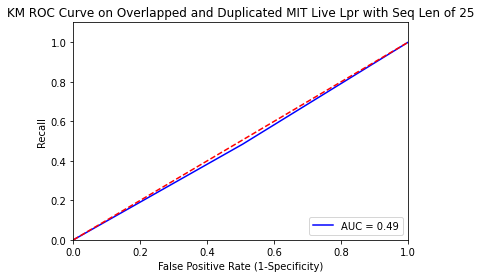

Test AUC: 0.489



--------------------KM on unclean data --------------------
Confusion Matrix: 
 [[75 44]
 [ 9 11]]

Testing Accuracy: 0.62
Precision:0.20
Recall: 0.55
False Positive Rate: 0.37

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       119
           1       0.20      0.55      0.29        20

    accuracy                           0.62       139
   macro avg       0.55      0.59      0.52       139
weighted avg       0.79      0.62      0.67       139

AUC: 0.59


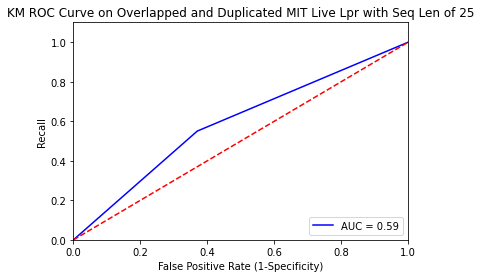

Test AUC: 0.590


In [69]:
## TESTING K-MEANS with clean data and unclean data
KM_clean_perf   = test_model(test_clean, y_test_clean, kmeans, 'KM', 'clean'); print('\n\n')
KM_unclean_perf = test_model(test_unclean, y_test_unclean, kmeans, 'KM', 'unclean')

write_to_file(KM_clean_perf, 'KM', 'clean')
write_to_file(KM_unclean_perf, 'KM', 'unclean')

# **Logistic Regression**

--------------------LR on clean data --------------------
Confusion Matrix: 
 [[37 56]
 [15 16]]

Testing Accuracy: 0.43
Precision:0.22
Recall: 0.52
False Positive Rate: 0.60

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.40      0.51        93
           1       0.22      0.52      0.31        31

    accuracy                           0.43       124
   macro avg       0.47      0.46      0.41       124
weighted avg       0.59      0.43      0.46       124

AUC: 0.46


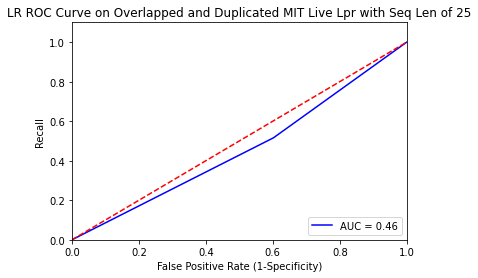

Test AUC: 0.457



--------------------LR on unclean data --------------------
Confusion Matrix: 
 [[68 51]
 [ 8 12]]

Testing Accuracy: 0.58
Precision:0.19
Recall: 0.60
False Positive Rate: 0.43

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.57      0.70       119
           1       0.19      0.60      0.29        20

    accuracy                           0.58       139
   macro avg       0.54      0.59      0.49       139
weighted avg       0.79      0.58      0.64       139

AUC: 0.59


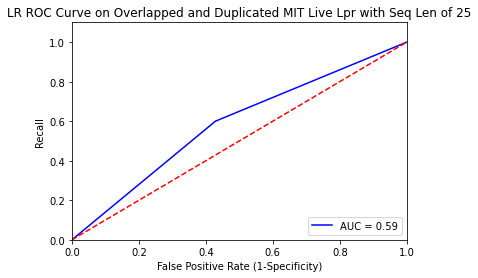

Test AUC: 0.586


In [70]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set
lgModel = LogisticRegression().fit(x_train, y_train)
#y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
#LR_train = {}
#LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
#LR_train['auc'] = roc_auc_score(y_train, y_pred)

## TESTING Logistic Regression with clean data and unclean data
LR_clean_perf   = test_model(test_clean, y_test_clean, lgModel, 'LR', 'clean'); print('\n\n')
LR_unclean_perf = test_model(test_unclean, y_test_unclean, lgModel, 'LR', 'unclean')

In [71]:
# Save performance to text file
write_to_file(LR_clean_perf, 'LR', 'clean')
write_to_file(LR_unclean_perf, 'LR', 'unclean')

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






In [72]:
if len(x_train) > 500000: 
  svm_sz = 0.1  
elif len(x_train) > 100000:
  svm_sz = 0.2
else:
  svm_sz = 1

svm_sz

0.2

In [73]:

train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = svm_sz)
train_data.reset_index(drop=True, inplace= True)
#train_data
svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
1,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3
2,113,20,94,20,101,51,89,101,144,129,86,90,122,113,6,38,5,128,3,19,4,6,57,8,57
3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
4,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48745,106,105,104,104,106,105,104,104,106,105,104,104,106,9,9,9,9,5,3,5,5,-1,-1,-1,-1
48746,4,138,66,5,23,45,4,27,66,5,4,2,66,66,5,4,2,66,66,5,5,105,104,104,106
48747,5,112,19,93,19,100,50,88,100,143,128,85,89,121,112,5,17,4,127,2,18,3,5,56,7
48748,106,105,104,104,106,105,104,104,106,105,104,104,106,83,59,4,2,2,2,2,2,2,2,2,2



****Polynomial kernel model: 
--------------------SVM on clean data --------------------
Confusion Matrix: 
 [[54 39]
 [16 15]]

Testing Accuracy: 0.56
Precision:0.28
Recall: 0.48
False Positive Rate: 0.42

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.58      0.66        93
           1       0.28      0.48      0.35        31

    accuracy                           0.56       124
   macro avg       0.52      0.53      0.51       124
weighted avg       0.65      0.56      0.59       124

AUC: 0.53


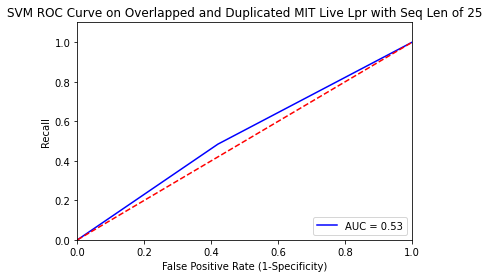

Test AUC: 0.532



--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[87 32]
 [14  6]]

Testing Accuracy: 0.67
Precision:0.16
Recall: 0.30
False Positive Rate: 0.27

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       119
           1       0.16      0.30      0.21        20

    accuracy                           0.67       139
   macro avg       0.51      0.52      0.50       139
weighted avg       0.76      0.67      0.71       139

AUC: 0.52


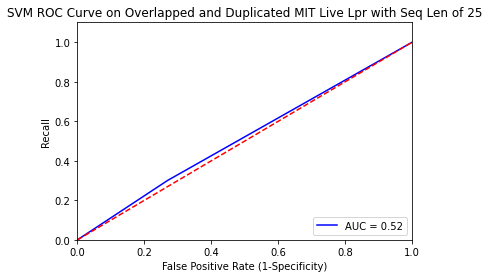

Test AUC: 0.516


In [74]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly')

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)
#y_pred = svm_model.predict(svm_x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
#SVM_train = {}
#SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(svm_y_train, y_pred)
#SVM_train['auc'] = roc_auc_score(svm_y_train, y_pred)


## TESTING SVM with clean data and unclean data
SVM_clean_perf   = test_model(test_clean,   y_test_clean,   svm_model, 'SVM', 'clean'); print('\n\n')
SVM_unclean_perf = test_model(test_unclean, y_test_unclean, svm_model, 'SVM', 'unclean')

# Save performance to text file
write_to_file(SVM_clean_perf, 'SVM', 'clean')
write_to_file(SVM_unclean_perf, 'SVM', 'unclean')

 Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [75]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in UNM data is 181
max_syscall = 181
x_train_nn = x_train/max_syscall
x_test_nn = x_test/max_syscall

In [76]:
import tensorflow as tf
from tensorflow import keras
INPUT_SZ = len(x_train.columns)
nn_model = keras.Sequential([
    keras.layers.Input(shape = (INPUT_SZ,)),           # model expect input to be a vector of 6 numbers
    keras.layers.Dense(INPUT_SZ, activation = 'relu'), 
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size= 32, verbose=1)  

Epoch 1/10
7618/7618 [==============================] - 13s 2ms/step - loss: 0.3713 - accuracy: 0.8638
Epoch 2/10
7618/7618 [==============================] - 12s 2ms/step - loss: 0.2696 - accuracy: 0.8933
Epoch 3/10
7618/7618 [==============================] - 13s 2ms/step - loss: 0.2179 - accuracy: 0.9214
Epoch 4/10
7618/7618 [==============================] - 12s 2ms/step - loss: 0.1976 - accuracy: 0.9279
Epoch 5/10
7618/7618 [==============================] - 14s 2ms/step - loss: 0.1872 - accuracy: 0.9313
Epoch 6/10
7618/7618 [==============================] - 12s 2ms/step - loss: 0.1795 - accuracy: 0.9336
Epoch 7/10
7618/7618 [==============================] - 12s 2ms/step - loss: 0.1739 - accuracy: 0.9352
Epoch 8/10
7618/7618 [==============================] - 12s 2ms/step - loss: 0.1696 - accuracy: 0.9367
Epoch 9/10
7618/7618 [==============================] - 12s 2ms/step - loss: 0.1662 - accuracy: 0.9375
Epoch 10/10
7618/7618 [==============================] - 12s 2ms/step - l

--------------------NN on clean data --------------------
Confusion Matrix: 
 [[44 49]
 [18 13]]

Testing Accuracy: 0.46
Precision:0.21
Recall: 0.42
False Positive Rate: 0.53

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.47      0.57        93
           1       0.21      0.42      0.28        31

    accuracy                           0.46       124
   macro avg       0.46      0.45      0.42       124
weighted avg       0.58      0.46      0.50       124

AUC: 0.45


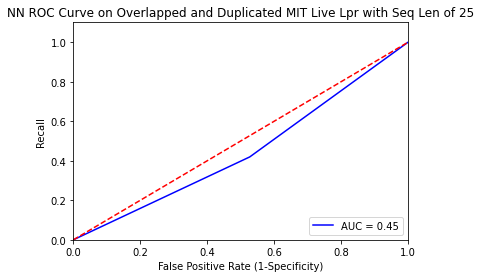

Test AUC: 0.446



--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[70 49]
 [ 7 13]]

Testing Accuracy: 0.60
Precision:0.21
Recall: 0.65
False Positive Rate: 0.41

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71       119
           1       0.21      0.65      0.32        20

    accuracy                           0.60       139
   macro avg       0.56      0.62      0.52       139
weighted avg       0.81      0.60      0.66       139

AUC: 0.62


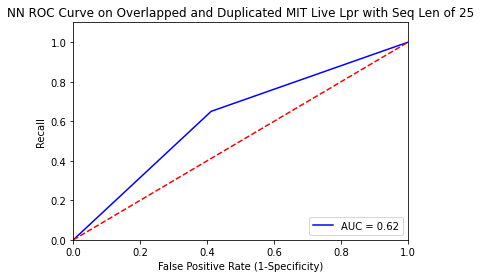

Test AUC: 0.619


In [77]:
# Get predicted Training labels
#y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
#NN_train = {}
#NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
#NN_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING NN with clean data and unclean data
NN_clean_perf   = test_model(test_clean,   y_test_clean,   nn_model, 'NN', 'clean'); print('\n\n')
NN_unclean_perf = test_model(test_unclean, y_test_unclean, nn_model, 'NN', 'unclean')

In [78]:
nn_model.summary()

#history.history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dense_3 (Dense)             (None, 2)                 52        
                                                                 
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Save performance to text file
write_to_file(NN_clean_perf, 'NN', 'clean')
write_to_file(NN_unclean_perf, 'NN', 'unclean')

# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

--------------------DT on clean data --------------------
Confusion Matrix: 
 [[83 10]
 [14 17]]

Testing Accuracy: 0.81
Precision:0.63
Recall: 0.55
False Positive Rate: 0.11

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        93
           1       0.63      0.55      0.59        31

    accuracy                           0.81       124
   macro avg       0.74      0.72      0.73       124
weighted avg       0.80      0.81      0.80       124

AUC: 0.72


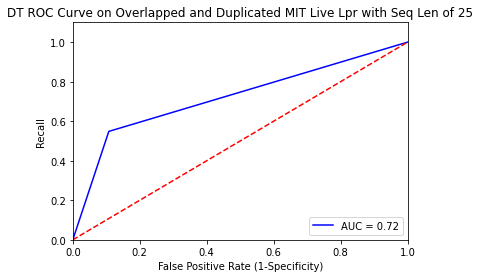

Test AUC: 0.720



--------------------DT on unclean data --------------------
Confusion Matrix: 
 [[109  10]
 [  8  12]]

Testing Accuracy: 0.87
Precision:0.55
Recall: 0.60
False Positive Rate: 0.08

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       119
           1       0.55      0.60      0.57        20

    accuracy                           0.87       139
   macro avg       0.74      0.76      0.75       139
weighted avg       0.88      0.87      0.87       139

AUC: 0.76


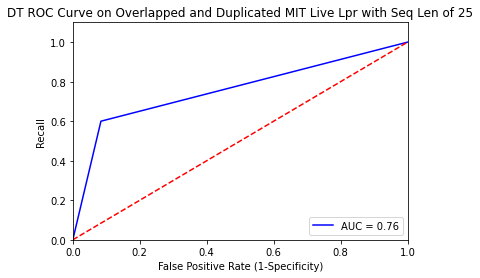

Test AUC: 0.758


In [80]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
#y_pred = decTree.predict(x_train)
#DT_train = {}
#DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
#DT_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING DT with clean data and unclean data
DT_clean_perf   = test_model(test_clean,   y_test_clean,   decTree, 'DT', 'clean'); print('\n\n')
DT_unclean_perf = test_model(test_unclean, y_test_unclean, decTree, 'DT', 'unclean')

# Save performance to text file
write_to_file( DT_clean_perf, 'DT', 'clean')
write_to_file( DT_unclean_perf, 'DT', 'unclean')


# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.


--------------------RF on clean data --------------------
Confusion Matrix: 
 [[93  0]
 [12 19]]

Testing Accuracy: 0.90
Precision:1.00
Recall: 0.61
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        93
           1       1.00      0.61      0.76        31

    accuracy                           0.90       124
   macro avg       0.94      0.81      0.85       124
weighted avg       0.91      0.90      0.89       124

AUC: 0.81


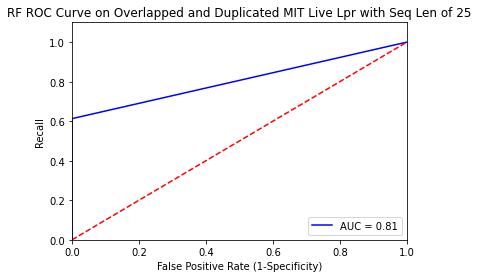

Test AUC: 0.806



--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[119   0]
 [  8  12]]

Testing Accuracy: 0.94
Precision:1.00
Recall: 0.60
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       119
           1       1.00      0.60      0.75        20

    accuracy                           0.94       139
   macro avg       0.97      0.80      0.86       139
weighted avg       0.95      0.94      0.94       139

AUC: 0.80


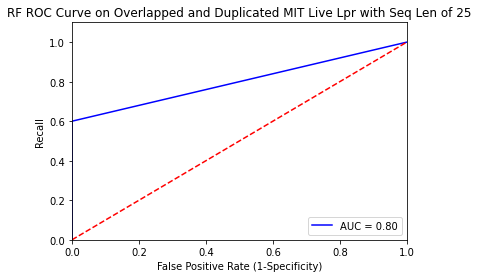

Test AUC: 0.800


In [81]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
#y_pred = randomForest.predict(x_train)
#RF_train = {}
#RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
#RF_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING RF with clean data and unclean data
RF_clean_perf   = test_model(test_clean,   y_test_clean,   randomForest, 'RF', 'clean'); print('\n\n')
RF_unclean_perf = test_model(test_unclean, y_test_unclean, randomForest, 'RF', 'unclean')


# Save performance to text file
write_to_file( RF_clean_perf, 'RF', 'clean')
write_to_file( RF_unclean_perf, 'RF', 'unclean')

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

--------------------KNN on clean data --------------------
Confusion Matrix: 
 [[66 27]
 [16 15]]

Testing Accuracy: 0.65
Precision:0.36
Recall: 0.48
False Positive Rate: 0.29

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        93
           1       0.36      0.48      0.41        31

    accuracy                           0.65       124
   macro avg       0.58      0.60      0.58       124
weighted avg       0.69      0.65      0.67       124

AUC: 0.60


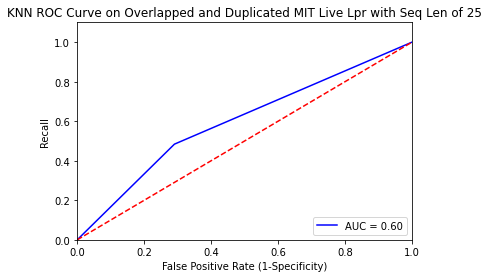

Test AUC: 0.597



--------------------KNN on unclean data --------------------
Confusion Matrix: 
 [[91 28]
 [ 8 12]]

Testing Accuracy: 0.74
Precision:0.30
Recall: 0.60
False Positive Rate: 0.24

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       119
           1       0.30      0.60      0.40        20

    accuracy                           0.74       139
   macro avg       0.61      0.68      0.62       139
weighted avg       0.83      0.74      0.77       139

AUC: 0.68


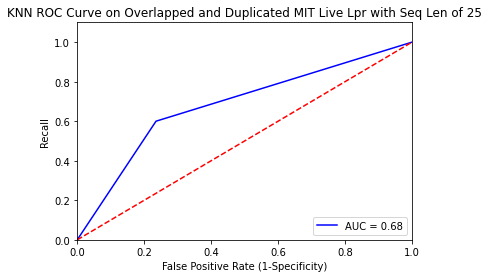

Test AUC: 0.682


In [82]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
#y_pred = KNN.predict(x_train)
#KNN_train = {}
#KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
#KNN_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING KNN with clean data and unclean data
KNN_clean_perf   = test_model(test_clean,   y_test_clean,   KNN, 'KNN', 'clean'); print('\n\n')
KNN_unclean_perf = test_model(test_unclean, y_test_unclean, KNN, 'KNN', 'unclean')

# Save performance to text file
write_to_file( KNN_clean_perf, 'KNN', 'clean')
write_to_file( KNN_unclean_perf, 'KNN', 'unclean')


# **Naive Bayes**

--------------------NB on clean data --------------------
Confusion Matrix: 
 [[35 58]
 [16 15]]

Testing Accuracy: 0.40
Precision:0.21
Recall: 0.48
False Positive Rate: 0.62

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.38      0.49        93
           1       0.21      0.48      0.29        31

    accuracy                           0.40       124
   macro avg       0.45      0.43      0.39       124
weighted avg       0.57      0.40      0.44       124

AUC: 0.43


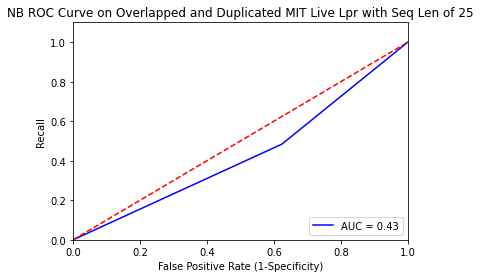

Test AUC: 0.430



--------------------NB on unclean data --------------------
Confusion Matrix: 
 [[57 62]
 [ 8 12]]

Testing Accuracy: 0.50
Precision:0.16
Recall: 0.60
False Positive Rate: 0.52

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62       119
           1       0.16      0.60      0.26        20

    accuracy                           0.50       139
   macro avg       0.52      0.54      0.44       139
weighted avg       0.77      0.50      0.57       139

AUC: 0.54


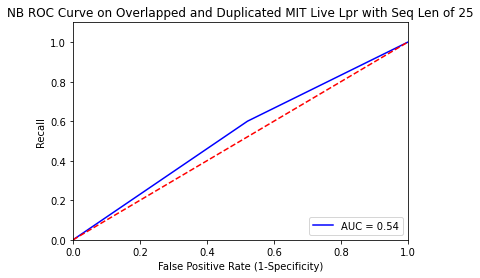

Test AUC: 0.539


In [83]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
#y_pred = NaiveBayes.predict(x_train)
#NB_train = {}
#NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
#NB_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING KNN with clean data and unclean data
NB_clean_perf   = test_model(test_clean,   y_test_clean,   NaiveBayes, 'NB', 'clean'); print('\n\n')
NB_unclean_perf = test_model(test_unclean, y_test_unclean, NaiveBayes, 'NB', 'unclean')


# Save performance to text file
write_to_file(NB_clean_perf, 'NB', 'clean')
write_to_file(NB_unclean_perf, 'NB', 'unclean')

# **End**

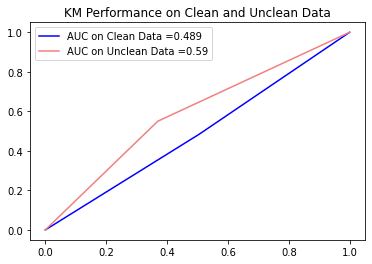

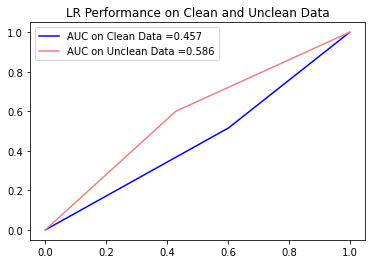

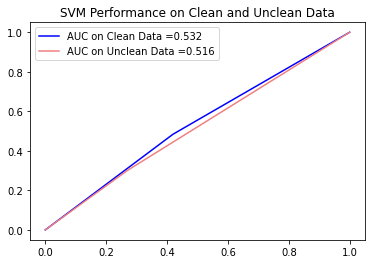

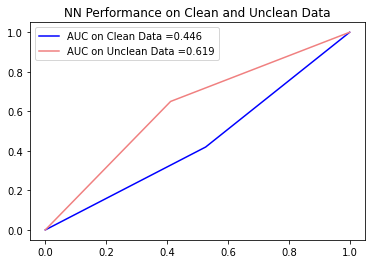

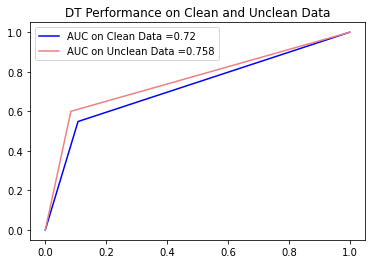

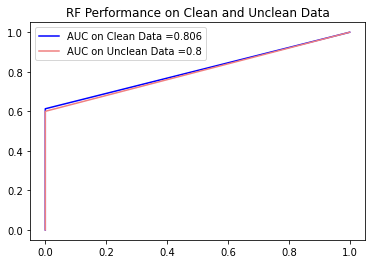

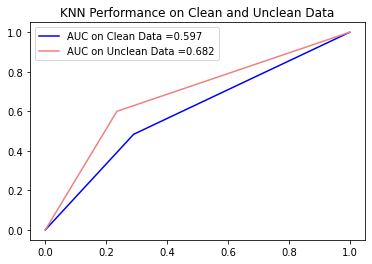

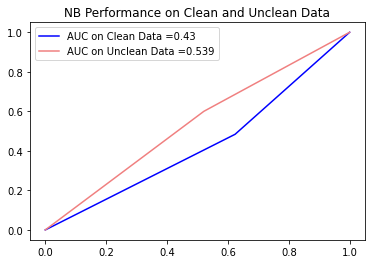

In [84]:
def plot_ROC_Clean_Unclean(clean, unclean, model_name):
  colors = {'unclean': 'lightcoral','clean': 'blue'}

  plt.plot(clean.get('fpr'), clean.get('tpr'), color=colors.get('clean'),  label= "AUC on Clean Data =" + str( round(clean.get('auc'), 3) ) )   
  plt.plot(unclean.get('fpr'), unclean.get('tpr'), color=colors.get('unclean'),  label= "AUC on Unclean Data =" + str( round(unclean.get('auc'), 3) ) )   
  plt.title(model_name +' Performance on Clean and Unclean Data')
  plt.legend()
  plt.show()

plot_ROC_Clean_Unclean(KM_clean_perf, KM_unclean_perf, 'KM')
plot_ROC_Clean_Unclean(LR_clean_perf, LR_unclean_perf, 'LR')
plot_ROC_Clean_Unclean(SVM_clean_perf, SVM_unclean_perf, 'SVM')
plot_ROC_Clean_Unclean(NN_clean_perf, NN_unclean_perf, 'NN')
plot_ROC_Clean_Unclean(DT_clean_perf, DT_unclean_perf, 'DT')
plot_ROC_Clean_Unclean(RF_clean_perf, RF_unclean_perf, 'RF')
plot_ROC_Clean_Unclean(KNN_clean_perf, KNN_unclean_perf, 'KNN')
plot_ROC_Clean_Unclean(NB_clean_perf, NB_unclean_perf, 'NB')


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (DATA, SEQ_LEN, CLEAN ):
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str( round(KM_test.get('auc'), 3) ) )   
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str( round(LR_test.get('auc'),3) ) )
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str( round(SVM_test.get('auc'), 3) ) )
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str( round(NN_test.get('auc'), 3) ) )
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_test.get('auc'), 3) ) )
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_test.get('auc'), 3) ) )
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_test.get('auc'), 3) ) )
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str( round(NB_test.get('auc'), 3) ) )
  try:
    plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
    plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))
  except NameError:
    print('\nBERT_test and GPT_test do not exist\n')

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs %s on %s with seq len of %d' % (CLEAN, DATA, SEQ_LEN) )
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()


# Func load_dict loads the dictionary contents extracted from the text file to a given variable name (stored in varname str)
# Output is a global dict variable 
# Input format:
## varname: a string of variable name
## dictvar: a dict containing the dictionary contents extracted from the text file
def load_dict(varname, dictvar):
  exec('%s = {}' %(varname), globals() )
  for key, value in dictvar.items():
    #print(key,":", value)
    exec('%s[%s] = %s' % (varname, key, value), globals())

# Func localFile extract the contents of each dictionary variables and load them into a dictionary
# Output: All the dictionaries from the text file will be loaded to the program
#  Input format: a text file containing multiple dictionaries, where each dict has this format:
## KM_test = {'fpr': array([0.        , 0.86136255, 1.        ]), 'tpr': array([0.        , 0.49007655, 1.        ]), 'auc': 0.31435699935689737}
## This function reads in each line, process the string and load it as a dict variable
## In the end, this function loads global variables based on each line of text
def load_dict_from_text (localFile):
  with open(localFile) as infile_object : 
    lines = infile_object.read().splitlines()    # Open and read each line
    measures = {}                                # stores elements of a dict
  for line in lines: 
    words = line.strip("\n ").split(' = ')     # remove whitespace and split str to get var name. words[0] contains var name, words[1] contains the phrase that goes after '='
    values = words[1].strip(" {} ").split('), ') # remove the whitespace and '{}', then split the second part of words to get each element in dict
    # iterate through each key-value pairelement and process them to get specific key-value pair
    for v in values:  
      elements = v.split(': ')                   # split key value pair by ':'. elements[0] is key, elements[1] is value
      elements[1] = elements[1].strip('array(')  # remove 'array(' from the value
      #print(elements[0]) print(elements[1])
      measures[ elements[0] ] = elements[1]      # save the key-value pairs found in a line into measures dict

    load_dict(words[0], measures)                # load the content of measures dict into the variable name stored in words[0]
        


In [85]:
       
#fileName = 'MIT Live Lpr-pm.txt'
#load_dict_from_text(fileName)

clean_status = 'clean' if CLEAN else 'unclean'
graph_multi_ROC(DATA, SEQ_WINDOW, clean_status)

## **Note**

Synthetic Sendmail dataset contains some sequences with only 6 system calls. Therefore we padded on the right with -1 on these small sequences, so that the sequence length can be 15.
After cleaning, there are 2021 unique normal sequences, while there are 423 unique intrusion sequences. This dataset is imbalanced. 

BERT and GPT significantly outperform the rest of the models with AUC above 0.95, while the others perform poorly on this dataset (AUC around 0.5)


